# **Content Recommendation System on Video Streaming Site**

##### Imports and database download

In [ ]:
# imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import math
import random

# functions from git repo
import shutil
shutil.rmtree('COMP432_Project', ignore_errors=True)
!git clone https://github.com/jasondinh99/COMP432_Project.git
from COMP432_Project.utils import time_to_rating, df_to_rating

random.seed(0);
torch.manual_seed(0);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cloning into 'COMP432_Project'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 38 (delta 13), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (38/38), 18.12 KiB | 2.01 MiB/s, done.


In [ ]:
# !gdown 10_FDsWmWdeWZI-AavTbW54y2CLpKBUCz    # Complete Dataset with 124 million entries
!gdown 13lbPDxlEI-ceKCR0H2a9glrgAOukV_Vt    # First 100k users with 3 million entries

Downloading...
From: https://drive.google.com/uc?id=13lbPDxlEI-ceKCR0H2a9glrgAOukV_Vt
To: /content/100k_a.csv
100% 114M/114M [00:00<00:00, 334MB/s] 


## **Abstract**
   This project report presents the development of a personalized recommendation system for Twitch live-stream viewers using machine learning techniques. The system is built on a dataset of Twitch user interactions collected by the University of California San Diego[\[1\]](https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch) over 43 days, including user and streamer IDs, start and stop times, and streamer usernames. The objective is to provide users with personalized recommendations based on their viewing history, by doing so, you can increase engagement and retention on the platform. For this project, I developed Machine Learning models using collaborative filtering and content-based filtering techniques to make predictions about users' preferences and recommend relevant streamers.


## **Introduction**

Live streaming is current one of the most popular entertainments on the Internet, with millions of users watching and broadcasting content every day from multiple big platforms, such as YouTube, Twitch, etc. However, with such a large number of streams available, it can be challenging for users to find new content that they will enjoy, and for streamers to attract a larger audience. Recommendation systems can help address this issue by suggesting content to users that is likely to be of interest to them. This benefits all parties, allowing viewers to explore new different contents that they might enjoy, helping streamers identify potential new viewers, and bringing in more revenue for the platform itself.

In this project, I explore one of the popular approaches for building recommendation systems, collaborative filtering using matrix factorization, where the user-item matrix is factorized into two lower dimensional matrices representing users and items respectively. By doing so, the model learns the latent factors that influence the user's preferences and recommends items accordingly. Matrix factorization-based collaborative filtering is often more effective than other forms of collaborative filtering, user-based and content-based filtering, as it can handle the sparsity of the user-item matrix and can provide personalized recommendations even for new or sparse items. 

This is different from the previous approach by the University of California San Diego, which incorporates Dynamic Availability and Repeat Consumption. The model that they develop can be found on their [GitHub repo](https://github.com/JRappaz/liverec). Later in this project, we will have a look at the result that this model give us and make a comparison with the model that I develop. Same as their model, I will be using the dataset that they collected:
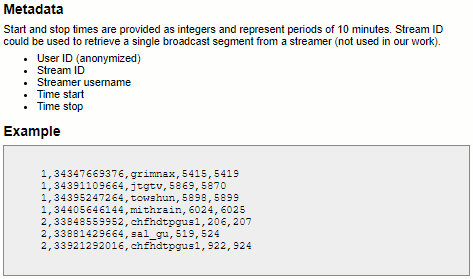

## **Methodology**

In this project, I aimed to build a Collaborative Filtering recommendation system for Twitch streamers. I used the Twitch dataset that contains user ratings for various streamers. I begin by loading the data into a pandas dataframe and preprocess the dataset. First I calculated the total watchtimes that each user spent on watching each streamers by using the start and stop times. The sum watchtimes per streamer is then converted into a scoring system that I personally created. The scores range from 1 to 10, the longer a user watches a streamer, the higher the score is. Before this transformed dataset can be used, we would need to convert both the users' and streamers' names into ID values so that they can be used for the training model. Finally, the dataset is split into training and testing sets with a 80-20 ratio, respectively. We use the `train_test_split` function from `sklearn` to perform this split. The functions for data preprocessing are in the `utils.py` file that on the this project's git repo as well as in the submission.

In [ ]:
df = pd.read_csv('100k_a.csv', header=None, names=["user","stream","streamer","start","stop"])

data = df_to_rating(df)     # Convert watchtime values to rating

In [ ]:
data.user, users = pd.factorize(data.user)
data.streamer, streamers = pd.factorize(data.streamer)

user_names = list(users)
streamer_names = list(streamers)
num_users = data.user.nunique()
num_streamers = data.streamer.nunique()

print("Total users: ", num_users)
print("Total streamers: ", num_streamers)
print("Number of data entries: ", len(data))

Total users:  100000
Total streamers:  162625
Number of data entries:  1505158


The dataset will be stored in a PyTorch dataset for easier processing. The TwitchDataset class is used to create PyTorch datasets from the training and testing sets. Since this is a huge dataset, with over 1 millions entries after preprocessing, I will use the DataLoader class  to create batches of data for training and testing, in order to try to get the most accurate result possible.

In [ ]:
class TwitchDataset:
    """
    A PyTorch dataset for Twitch data.

    Args:
        data (pandas.DataFrame): The Twitch data as a Pandas DataFrame with
            columns 'user', 'streamer', and 'rating'.

    Attributes:
        users (numpy.ndarray): An array of user IDs.
        streamers (numpy.ndarray): An array of streamer IDs.
        ratings (numpy.ndarray): An array of integer ratings.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index: int): Returns a dictionary with 'users', 'streamers', and 'ratings'
            as keys and corresponding PyTorch tensors as values.
    """
    def __init__(self, data):
        self.users = data.user.values
        self.streamers = data.streamer.values
        self.ratings = data.rating.values

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        return {
            'users': torch.tensor(self.users[index], dtype=torch.long),
            'streamers': torch.tensor(self.streamers[index], dtype=torch.long),
            'ratings': torch.tensor(self.ratings[index], dtype=torch.long)
        }

The main idea or concept in this algorithm is that network learns the similarity between two streamers based on the watch history of different users. Collaborative filtering is used by most recommendation systems to find similar patterns or information of the users, this technique can filter out items that users like on the basis of the ratings or reactions by similar users [2].

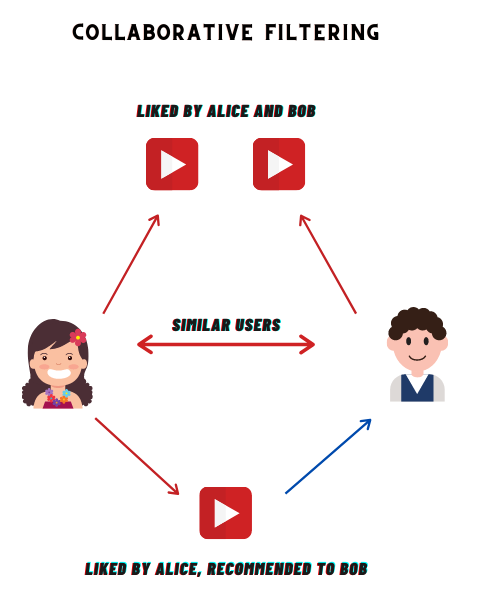

I defined a CollabFilter class as a PyTorch module, that extends the nn.Module class from PyTorch for our recommendation system, which consists of two embedding layers, one for the users and the other for the streamers, with a specified embedding_size. We use a dropout layer to prevent overfitting, and a Linear layer with one output to predict the rating.

In [ ]:
class CollabFilter(nn.Module):
    """
    PyTorch model for neural collaborative filtering.

    Args:
        n_users (int): The number of unique user IDs in the input data.
        n_streamers (int): The number of unique streamer IDs in the input data.
        embedding_size (int): The size of the user and streamer embeddings.
        dropout (float): The dropout probability.

    Attributes:
        user_embedding (nn.Embedding): The user embedding layer.
        streamer_embedding (nn.Embedding): The streamer embedding layer.
        dropout (nn.Dropout): The dropout layer.
        out (nn.Linear): The output layer.

    Methods:
        forward(users: torch.Tensor, streamers: torch.Tensor) -> torch.Tensor:
            Computes the forward pass of the model.

            Args:
                users (torch.Tensor): A tensor of user IDs with shape (batch_size,)
                streamers (torch.Tensor): A tensor of streamer IDs with shape (batch_size,)

            Returns:
                torch.Tensor: A tensor of predicted ratings with shape (batch_size, 1).
    """
    def __init__(self, n_users, n_streamers, embedding_size=32, dropout=0.5):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_size)
        self.streamer_embedding = nn.Embedding(n_streamers, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_size*2, 1)
        
    def forward(self, users, streamers):
        user_embeddings = self.dropout(self.user_embedding(users))
        streamer_embeddings = self.dropout(self.streamer_embedding(streamers))
        prediction = torch.cat([user_embeddings, streamer_embeddings], dim=1)
        return self.out(prediction)

## **Experimental Setup**

After testing around with different hyperparameters, these are the hyperparameters that I've choosen to use.

In [ ]:
# Hyperparameters
embedding_size = 32
dropout = 0.5
lr = 0.001
epochs = 1
batch_size = 128
random_state = 0

In [ ]:
# Split dataset
train_data, test_data = model_selection.train_test_split(
    data, test_size=0.2, random_state=random_state, stratify=data.rating.values
)

train_dataset = TwitchDataset(data=train_data)
test_dataset = TwitchDataset(data=test_data)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

The model that we have for this project is trained using the dataset and mean square error (MSE) loss function. I also use `optim.Adam`, which implements rmsprop and momentum, to update the model parameters. In turn that results in an adaptive learning rate. The model is trained for epochs=1 with a batch_size of 128. The random_state is set to 0 for reproducibility. The reason why the model is trained with only 1 epoch is because the dataset that we use should be large enough for it to be sufficient. When I try run with more epochs, the loss value stay the same for higher epoches. We use the CollabFilter model above with a specified embedding_size of 32 and a dropout rate of 0.5. The training and testing sets are created using the train_test_split function, and the TwitchDataset class is used to create PyTorch datasets from them. Finally, the DataLoader class is used to create batches of data for training and testing.As the model is being trained, the average training loss is also printed and stored every 10,000 steps . This average training loss will be used to plot out and we can observe how the loss changes as the training process goes on.

In [ ]:
model = CollabFilter(n_users=num_users, n_streamers=num_streamers, embedding_size=embedding_size, dropout=dropout).to(device)

optimizer = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()

In [ ]:
plot_steps = 10000
all_losses_list = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    steps = 0
    for i, batch in enumerate(train_loader):
        prediction = model(batch["users"], batch["streamers"])
        rating = batch["ratings"].view(len(batch["ratings"]), -1).to(torch.float32)

        loss_value = loss(prediction, rating)
        total_loss += loss_value.sum().item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        steps = steps + len(batch["users"])

        if(steps % plot_steps == 0):
            avg_loss = total_loss/(len(batch["users"]) * plot_steps)
            print(f"epoch {epoch}, step {steps}: {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0

## **Experimental Results**

#### **LiveRec Model**

For the `LiveRec` model by the University of California San Diego, this is the result that the model gives us after running for 5 epoches. The original code is set to run up to 150 epoches, but because of how big the dataset is and how costly it is to run the model, we can settle with stopping after 5 epoches for this project.

```
Final score
===========
Epoch: 004, Loss: 1.11165
all: h@1: 0.34714 h@5: 0.56491 h@10: 0.58196 ndcg@1: 0.34714 ndcg@5: 0.47000 ndcg@10: 0.47561
new: h@1: 0.03300 h@5: 0.09668 h@10: 0.12707 ndcg@1: 0.03300 ndcg@5: 0.06561 ndcg@10: 0.07550
rep: h@1: 0.62118 h@5: 0.97337 h@10: 0.97879 ndcg@1: 0.62118 ndcg@5: 0.82277 ndcg@10: 0.82464
ratio:  0.5340901381696479
```
The full results is includes on my Git repository as well as in the submission.

The model was trained using batch size of 100, learning rate of 0.0005, and L2 regularization with a weight of 0.1.

#### **Collaborative Filtering Model**

During the training process, we monitored the average loss every plot_steps=10000 steps, and the results are stored in all_losses_list. After training, we evaluated the performance of the model on the test dataset by calculating the mean squared error (MSE) of the predictions. After training the model, this is the output that we should get.

The average loss per step during training was quite low at 0.000367. A low loss value might indicate that the model was able to converge to a reasonable solution. The MSE on the test dataset was 0.07, which indicates that the model was able to make reasonably accurate predictions on unseen data. However, if we have a run the model to get recommendations for different users, we will see a problem.

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.xticks(np.arange(0,15), np.linspace(80000, 1200000, 15))
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

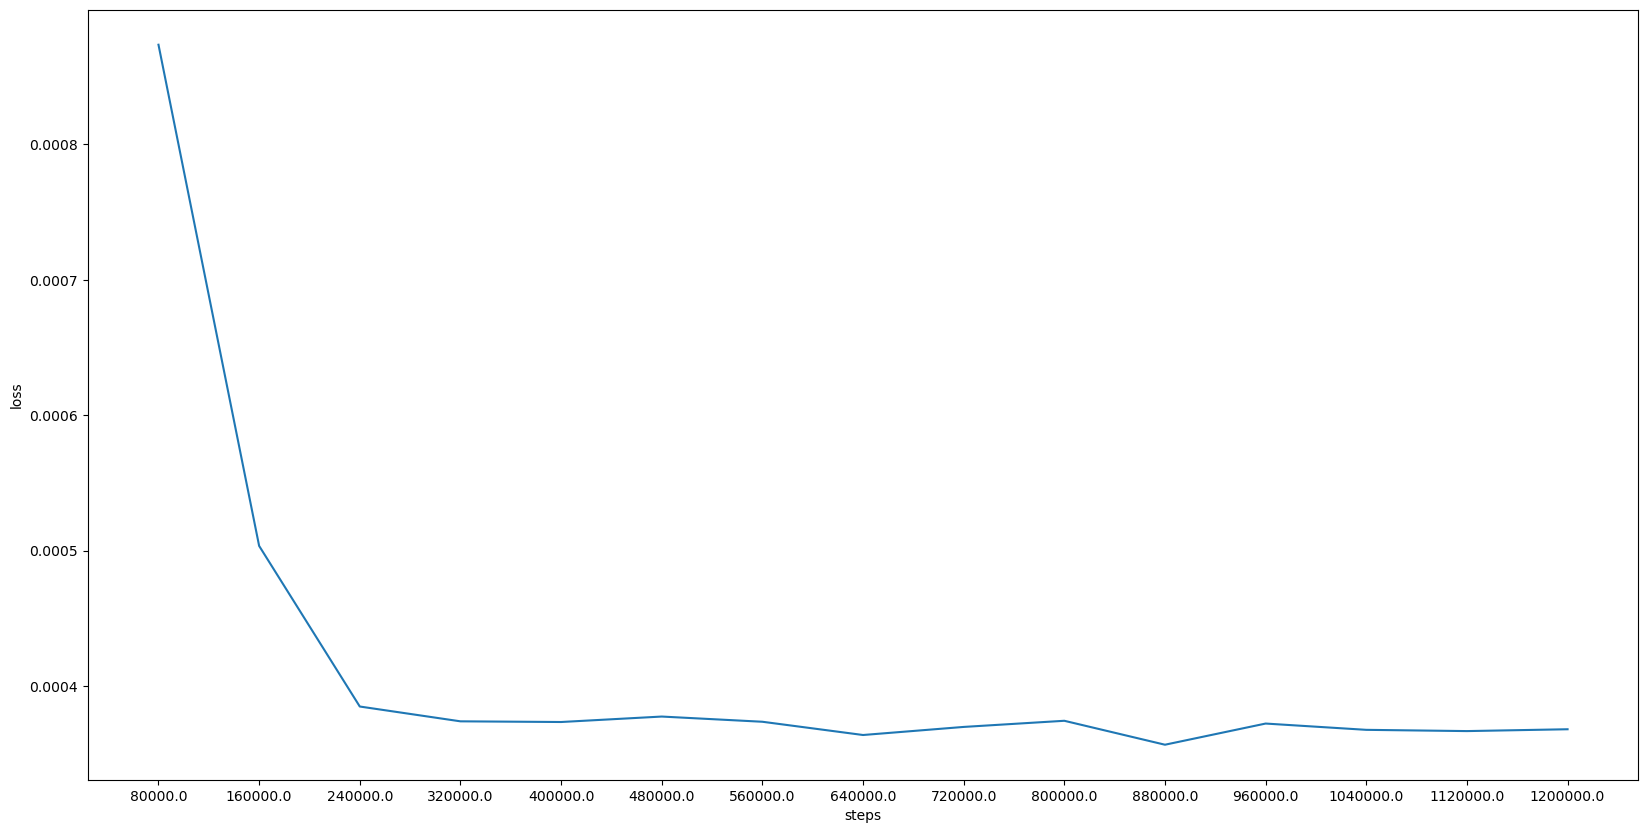

In [ ]:
predictions_list = []
targets_list = []

model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader): 
        prediction = model(batch['users'], batch["streamers"])
        predictions_list.append(prediction.sum().item() / len(batch['users']) )
        target = batch["ratings"]
        targets_list.append(target.sum().item() / len(batch['users']))
#         print(f"model_output: {prediction.view(-1)}, target_rating: {target}")

error = mean_squared_error(targets_list, predictions_list, squared=False)
print(f"Root mean squared error: {error}")

We can get the top recommendations for a user using this function:

In [ ]:
def recommend(user, users_list, streamers_list, num_recommendations=10):
    """
    Recommends a list of streamers to a user based on their predicted ratings, using a trained PyTorch model.

    Args:
    - user (int): the ID of the user to recommend streamers to.
    - users_list (list): a list of user IDs, where users_list[i] corresponds to the i-th row of the rating matrix.
    - streamers_list (list): a list of streamer IDs, where streamers_list[j] corresponds to the j-th column of the rating matrix.
    - num_recommendations (int, optional): the number of streamers to recommend. Default is 10.

    Returns:
    - None: prints the top num_recommendations recommended streamers for the user, along with their predicted scores.

    Raises:
    - None.

    Example usage:
    >>> recommend(0, users_list, streamers_list, num_recommendations=5)
    Top 10 recommendations for user 1:
    1. moonmoon_ow (predicted score = 1.6918)
    2. lord_kebun (predicted score = 1.6495)
    3. thecasper09 (predicted score = 1.6454)
    4. devinreviews (predicted score = 1.6297)
    5. dcn_dan (predicted score = 1.6225)
    """
    model.eval().eval()
    ratings = {}
    with torch.no_grad():
        for streamer in range(num_streamers):
            test = model(torch.tensor([user]), torch.tensor([streamer]))
            ratings[streamer] = test.item()
    top_streamers = sorted(ratings.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]

    recommendations = [(streamers_list[i[0]], i[1]) for i in top_streamers]
    print(f'Top {num_recommendations} recommendations for user {users_list[user]}:')
    for i, rec in enumerate(recommendations, 1):
        print(f'{i}. {rec[0]} (predicted score = {rec[1]:.4f})')

In [ ]:
recommend(0, user_names, streamer_names)
recommend(69, user_names, streamer_names)

If you run the code as they are you will be they following results:

```
Top 10 recommendations for user 1:
1. moonmoon_ow (predicted score = 1.6918)
2. lord_kebun (predicted score = 1.6495)
3. thecasper09 (predicted score = 1.6454)
4. devinreviews (predicted score = 1.6297)
5. dcn_dan (predicted score = 1.6225)
6. cure25 (predicted score = 1.6182)
7. digedog (predicted score = 1.6167)
8. playhearthstone (predicted score = 1.6116)
9. elwind (predicted score = 1.6095)
10. sbychan0 (predicted score = 1.6044)

Top 10 recommendations for user 70:
1. moonmoon_ow (predicted score = 1.6809)
2. lord_kebun (predicted score = 1.6387)
3. thecasper09 (predicted score = 1.6346)
4. devinreviews (predicted score = 1.6189)
5. dcn_dan (predicted score = 1.6116)
6. cure25 (predicted score = 1.6074)
7. digedog (predicted score = 1.6058)
8. playhearthstone (predicted score = 1.6007)
9. elwind (predicted score = 1.5987)
10. sbychan0 (predicted score = 1.5936)
```

We can see that there is one major limitation of our experiments, which is that the model only gave the same recommendations for every user. The prediction score for each users are different but the recommendations are the same. This could be due to a lack of diversity in the user ratings, which limits the ability of the model to differentiate between users.

Because of this problem, our results are not in line with other studies that have used similar techniques and datasets, making it hard to compare to their result.

After anlysing the dataset, this is what I found, these are the counts for all ratings in the dataset:

```
Rating      Counts
1          1194550
2           185688
3            71426
4            29668
5            12872
6             5858
7             2772
8             1248
9              615
10             461
```

We can see that the distribution of ratings in the dataset are not even for all ratings. This is most likely the main contributing factor for why the collaborative filtering model gives the same recommendations for every user. The dataset appears to be heavily skewed towards low ratings, with over 1 million ratings of 1 and relatively few high ratings. And so, all of the predicted scores are only between 1 and 2, as we see above.

## **Conclusions**

In this project, we used a Collaborative Filtering approach to build a recommendation system for Twitch streamers. Unfortunately, although the loss value and MSE value are low, our experiments showed that the model was not able to make accurate predictions on unseen data.

Even though Collaborative Filtering is a popular approach for building recommendation systems, the lack of diversity in the user ratings may be a major limitation, and it may be necessary to explore alternative approaches that can better handle this challenge. The skewed distribution of ratings in the dataset could be a factor contributing to the issue of the collaborative filtering model giving the same recommendations for every user. There are many possible solutions that could fix this problem. Better preprocessing the dataset by normalizing the ratings can help to reduce the impact of the skewed rating distribution and improve the accuracy of the recommendations. Another option can be using techniques such as weighted matrix factorization, bias correction, or pre-processing the data might help to mitigate this issue.

## **References**
1.   McAuley, Julian. "Recommender Systems and Personalization Datasets", *UCSD*,  https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch
2.   Baldha, Shivam. "Introduction to Collaborative Filtering", *Analytics Vidhya* https://www.analyticsvidhya.com/blog/2022/02/introduction-to-collaborative-filtering/